$$
\def\R{\mathbb{R}}
\def\dd{\mathrm{d}}
\def\ii{\mathrm{i}}
$$

# Computing the implied volatility skew in a rough Bergomi model

The purpose of this notebook is to compute the implied volatility skew in the rough Bergomi model using simulation.

Below you will find a code skeleton to be filled with crucial code blocks related to the generation of samples in the rough Bergomi model.

Remeber the model:
$$
\mathrm{d}S_t = S_t \sqrt{v}_t \mathrm{d}Z_t,\\
v_t = \xi_0(t) \exp\left( \eta \widetilde{W}_t - \frac{\eta^2}{2} t^{2H}\right),
$$
with $\widetilde{W}_t := \sqrt{2H} \int_0^t (t-s)^{H-1/2} \mathrm{d}W_s$, $Z_t = \rho W_t + \sqrt{1-\rho^2} W^\perp_t$.

As always, we assume that $r = 0$, and that we operate under a risk-neutral measure.

We start with importing some required packages.

In [1]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from scipy.special import gamma, hyp2f1
from typing import Callable
from finance import compute_call_surface
import matplotlib.pyplot as plt

Some magic to allowe interactive plots.

In [2]:
%matplotlib widget

We set up a class for storing the model parameters of the rough Bergomi model.

In [3]:
class rBergomiParameters:
    """
    Class for collecting the parameters of the rough Bergomi model.
    """
    def __init__(self, H:float, eta:float, rho: float, S0: float, 
                 xi0: Callable):
        """
        Paramaters
        ----------
        H : float
            Hurst parameter, between 0 and 1/2.
        eta : float
            vol-of-vol, positive.
        rho : float
            Correlation between the Bm driving the volatility and the 
            one driving the stock, between -1 and 1.
        S0 : float
            Spot price of the stock.
        xi0 : function
            Forward variance curve at initial time, a function of 
            time, expecting either a scalar or a numpy array, and 
            returning either a scalar or a numpy array.
        corMat : ndarray
            Correlation matrix of the driving Bms.
        """
        self.H = H
        self.eta = eta
        self.rho = rho
        self.S0 = S0
        self.xi0 = xi0
        self.corMat = np.array([[1, rho],[rho,1]])

We write a function simulating samples from the terminal value of the stock price. Below, we provide the expected function signature, but an incorrect implementation, which only samples a one-factor Bergomi model. More precisely, we use
$$
\mathrm{d} S_t = \sqrt{v_t} S_t \mathrm{d}Z_t,\\
v_t = \xi_0(0) \exp\left( \eta W_t - \frac{1}{2} \eta^2 t\right).
$$

Note that the following code is not returning the initial value $S_0$.

In [4]:
def simulate_rBergomi(T: float, N:int, M:int, params: rBergomiParameters, 
                      rng: np.random.Generator) -> np.ndarray:
    """
    Computes m final stock prices of the rough Bergomi model, using the approximation from Bayer, Friz, Gatheral.
    
    Parameters
    ----------
    T : float
        Terminal time.
    N : int
        Number of time-steps.
    M : int
        Number of samples.
    params : rBergomiParameters
        Parameters of the rough Bergomi model.
    rng : RNG
        Random number generator.
    
    Returns
    -------
    S : ndarray
        Array of samples from the distribution of (S_{T/N}, ..., S_T), 
        shape (M, N).
    """
    
    dW = rng.normal(0, 1, (M,N))
    dWperp = rng.normal(0, 1, (M,N))
    dt = T / N
    sigma2 = params.xi0(0)
    dZ = np.sqrt(dt) * (params.rho * dW + np.sqrt(1 - params.rho**2) * dWperp)

    tt = np.linspace(0, T, N+1)
    Wt = np.cumsum(np.concatenate([np.zeros((M,1)), dZ], axis=1), axis=1)
    vt = params.xi0(0) * np.exp(params.eta * Wt - 0.5 * params.eta**2 * tt)

    St = params.S0 * np.exp(np.cumsum(np.sqrt(vt[:,:-1]) * dZ - vt[:,:-1] * dt / 2, axis=1))
    return St


Next lets us compute an implied volatility surface. First define our parameters.

In [5]:
def set_rBergomi_params() -> rBergomiParameters:
    # First fix the parameters.
    H = 0.07
    eta = 2.3
    rho = -0.9
    S0 = 1
    def xi0(x):
        if np.isscalar(x):
            return 0.04
        else:
            return np.full_like(x, 0.04)
    return rBergomiParameters(H, eta, rho, S0, xi0)

params = set_rBergomi_params()

T = 1.5
M = 100_000
N = 1000
dt = T/N

strike_list = params.S0 * np.linspace(0.9, 1.2, 100)
maturities = np.arange(1, N+1) * dt # = dt, 2*dt, ..., T

Next simulate trajectories.

In [6]:
rng = np.random.default_rng()

St = simulate_rBergomi(T, N, M, params, rng)

Compute the implied volatility surface.

In [7]:
prices, stats, vols, vols_up, vols_down = compute_call_surface(maturities, St, strike_list)

/home/bayerc/anaconda3/envs/winterschool/lib/python3.14/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
/home/bayerc/anaconda3/envs/winterschool/lib/python3.14/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
/home/bayerc/anaconda3/envs/winterschool/lib/python3.14/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 

The values for very small maturities are unreliable, so we discard them.

In [8]:
mask = np.arange(50, N)

Plot the implied vol surface.

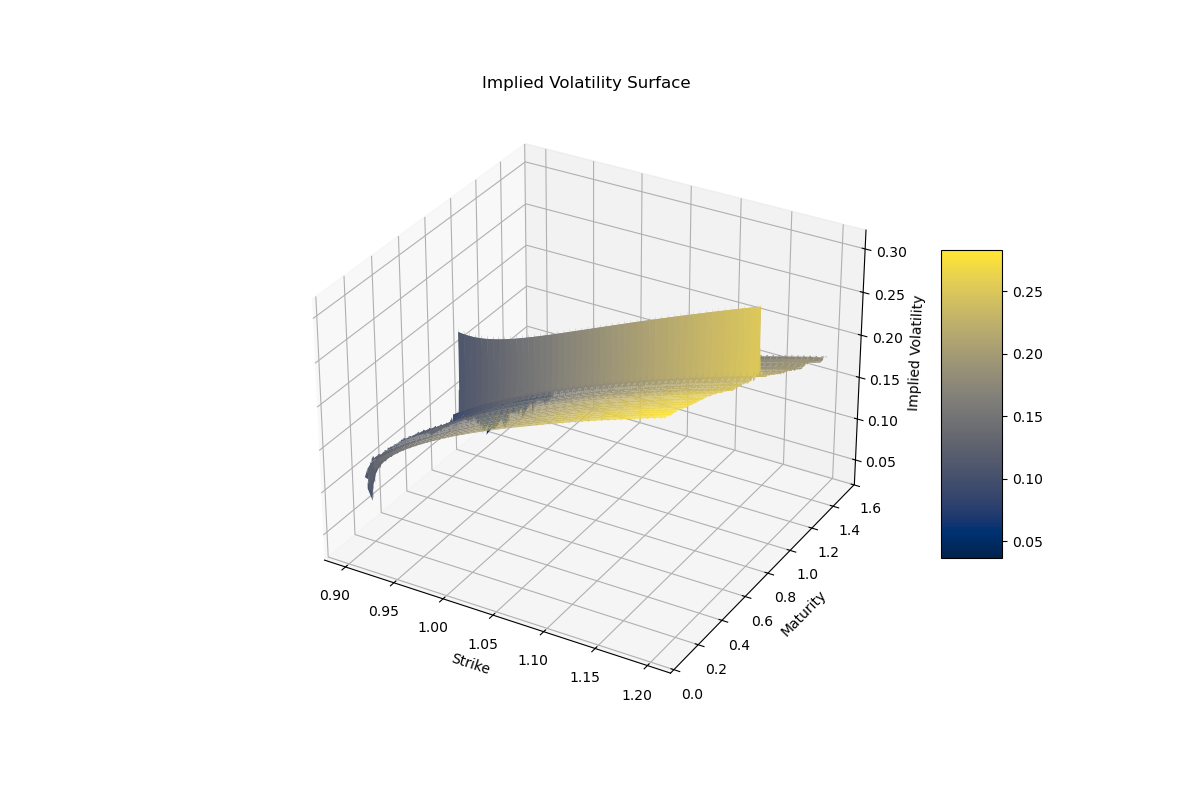

In [9]:
K_mesh, T_mesh = np.meshgrid(strike_list, maturities[mask])

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.view_init(elev=30, azim=-60)

# Plot the surface
surf = ax.plot_surface(K_mesh, T_mesh, vols[mask,:], cmap='cividis',
                           linewidth=0, antialiased=True)

# Add labels and title
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface')

# Add a color bar
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Finally, compute the ATM implies volatility skew by using central difference quotients, i.e.,
$$
\psi(t) \approx \frac{\sigma_{impl}(\Delta k/2, t) - \sigma_{impl}(-\Delta k/2, t)}{\Delta k},
$$
noting that $k = \pm \Delta k/2$ corresponds to $K = S_0 \mathrm{e}^{\pm \Delta k/2}$.

In [10]:
dk = 0.01
strike_list = params.S0 * np.exp(np.array([-dk/2, dk/2]))

prices, stats, vols, vols_up, vols_down = compute_call_surface(maturities, St, strike_list)

skews = (vols[:,1] - vols[:,0]) / dk

To check where we need to truncate for reasons of numerical errors, let us print the skews.

In [11]:
print(skews[0:20])

[0.19824964 0.46431658 0.506013   0.53074203 0.54506436 0.58791368
 0.5912687  0.59531438 0.59781047 0.61500295 0.60387184 0.62401428
 0.61880346 0.6027319  0.58818366 0.61350408 0.60705693 0.60469255
 0.59359431 0.59530385]


We mask the first four entries.

In [12]:
mask = np.arange(4, N)

Before plotting the skew, let us compute a simple logarithmic regression curve, i.e., $\psi(t) \approx \alpha t^\beta$, or $\log \psi(t) \approx \log(\alpha) + \beta \log(t)$.

In [13]:
new_series = Polynomial.fit(np.log(maturities[mask]), np.log(np.abs(skews[mask])), deg=1)
l_alpha, beta = new_series.convert().coef
alpha = np.exp(l_alpha)
print(f"beta = {beta}, H - 1/2 = {params.H - 0.5}")

beta = -0.049066409265198625, H - 1/2 = -0.43


Now plot the skews. To see the usual picture, we plot absolute values.

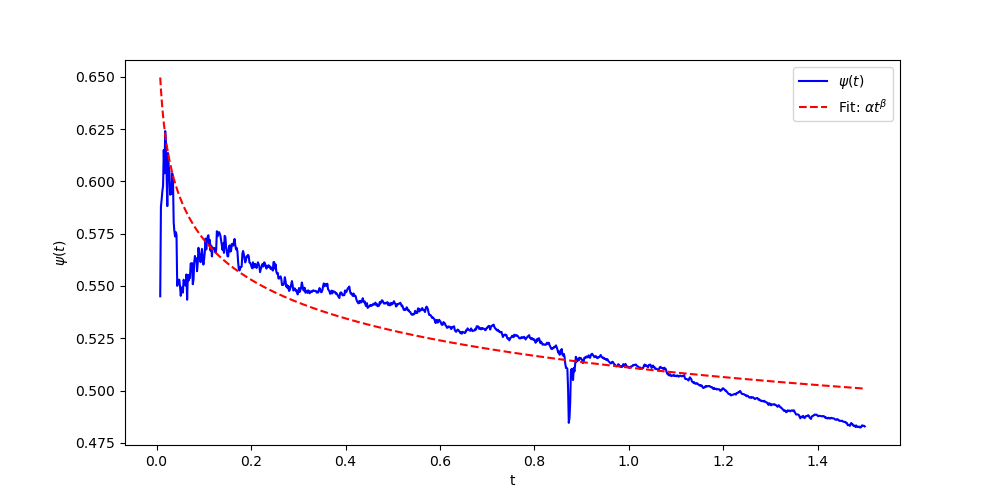

In [14]:
fig, ax  = plt.subplots(figsize=(10,5))
ax.plot(maturities[mask], np.abs(skews[mask]), "b-", label=r"$\psi(t)$")
ax.plot(maturities[mask], alpha * maturities[mask] ** beta, "r--", label=r"Fit: $\alpha t^{\beta}$")
ax.set_xlabel("t")
ax.set_ylabel(r"$\psi(t)$")
ax.legend()
